# Machine Learning for CO2 adsorption on porous carbons

## Problem´s description

Framing the problem: supervised, unsupervised or reinforcement learning? Is it classification or regression? Well, first of all it is a supervised learning, because each instance comes with the expected output (i.e. labeled data, like known porous carbon material has its measured CO2 uptake). Secondly, it is a regression taks and not classification since we have to predict a value for CO2 adsorption. More specifically, it is a multivariate regression since the system will use multiple features to generate the outcome.  

Porous carbons are known to adsorb CO2 on its surface. The main features of crbons surface are surface area (S BET), mesopores volume (V meso) and micropores volume (V micro). Which of the three factors is the major in CO2 adsorption is unknown. The CO2 uptake has also temperature (T) in which the measurements occured, and partial pressure (P).

I will utilize the machine learning to predict the CO2 uptake of the porous carbons with known surface properties - S BET, V micro, V meso, adsorption temperature (T) and pressure (P). For this purpose, I will extract the experimental data for the CO2 adsorption of different porous carbons from the literature. 
Surface characteristics as well as CO2 uptake of a bit more than 1000 porous carbons were described in this article. 

The first step is to extract the data from pdf-file so that we would obtain training set for our machine learning algorithms.  

## Data mining. Table clean-up

The table was downloaded from the supporting data of a published article on the CO2 adsorption:

https://onlinelibrary.wiley.com/doi/full/10.1002/anie.201812363

In order to extract the table data from the pdf file, a software tabula-py was used:

https://blog.chezo.uno/tabula-py-extract-table-from-pdf-into-python-dataframe-6c7acfa5f302

tabula is a greate package that allows for a table mining from pdf files with ease! The tables from the Supporting Info-file were extracted with "Tabula" in .tsv format and then opened as csv file using the following code:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame

df = DataFrame.from_csv("tabula-CO2_DNN_SI.tsv", sep="\t")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


Unfortunately, "Tabula" extracted table from the pdf-file in a very reader-unfriendly way - it is hard to read, most of the columns are misplaced and values are off. It means that we have to spend some time cleaning our table so that it will be readable.   
Let us have a look on what are the names of the columns:

In [2]:
columns_old = df.columns
columns_old

Index(['S BET (m /g)', '2', 'Unnamed: 3', 'V total (cm /g)', '3', 'Unnamed: 6',
       'Vmicro (cm /g) 3', 'Unnamed: 8', 'T(oC)', 'P(bar)',
       'CO2 uptake (mmol/g)'],
      dtype='object')

Since the table's layout is completely off, we generate the column names of those that we are interested in:

In [3]:
column_names = [columns_old[0],columns_old[3],columns_old[6], columns_old[8], columns_old[9], columns_old[10]]
column_names

['S BET (m /g)',
 'V total (cm /g)',
 'Vmicro (cm /g) 3',
 'T(oC)',
 'P(bar)',
 'CO2 uptake (mmol/g)']

In [4]:
df.head(14)

,S BET (m /g),2,Unnamed: 3,V total (cm /g),3,Unnamed: 6,Vmicro (cm /g) 3,Unnamed: 8,T(oC),P(bar),CO2 uptake (mmol/g)
Entry,,,,,,,,,,,
1,NaN,798.0,NaN,NaN,0.18,NaN,0.42,NaN,25.0,5.0,2.0
2,NaN,241.0,NaN,NaN,1.01,NaN,0.09,NaN,25.0,5.0,0.7
3,NaN,448.0,NaN,NaN,1.09,NaN,0.21,NaN,25.0,5.0,0.9
4,NaN,826.0,NaN,NaN,0.91,NaN,0.39,NaN,25.0,5.0,1.8
5,NaN,895.0,NaN,NaN,0.90,NaN,0.40,NaN,25.0,5.0,2.8
6,NaN,862.0,NaN,NaN,0.91,NaN,0.39,NaN,25.0,5.0,2.1
7,NaN,678.0,NaN,NaN,1.10,NaN,0.30,NaN,25.0,5.0,2.3
8,NaN,304.0,NaN,NaN,1.06,NaN,0.14,NaN,25.0,5.0,0.9
9,NaN,500.0,NaN,NaN,0.77,NaN,0.23,NaN,25.0,5.0,2.2


In [5]:
df['S BET (m /g)'] = df['S BET (m /g)'].fillna(df['2'])
df['V total (cm /g)'] = df['V total (cm /g)'].fillna(df['3'])

For the second column, V tottal, which is "2", the data are skewed from 1 to row 39. 
The data for this column are found in the column detoned as "V total".
We have to copy data for rows 1-39 from column "V total" to column "2"

In [6]:
df['2'][0:37] = df['V total (cm /g)'][0:37]  
df['2'] = df['2'].fillna(0.138)

In [7]:
# Now the columns 1 and 2 are fixed. Moving to the third column.
# Beginning of the column 3 is located in the column "V micro" and the end is the 
# column "Unnamed 3". Lets us check how many data points are missing in "Unnamed 3".
number_withNaNs = df['Unnamed: 3'].isnull().count() # data points including NaNs
number_values_noNaN = df['Unnamed: 3'].count()
diff = number_withNaNs - number_values_noNaN
diff

38

Ok, so there are 38 missing values and they are in the beginning of the table.

In [8]:
df[0:50].head()

,S BET (m /g),2,Unnamed: 3,V total (cm /g),3,Unnamed: 6,Vmicro (cm /g) 3,Unnamed: 8,T(oC),P(bar),CO2 uptake (mmol/g)
Entry,,,,,,,,,,,
1,798.0,0.18,NaN,0.18,0.18,NaN,0.42,NaN,25.0,5.0,2.0
2,241.0,1.01,NaN,1.01,1.01,NaN,0.09,NaN,25.0,5.0,0.7
3,448.0,1.09,NaN,1.09,1.09,NaN,0.21,NaN,25.0,5.0,0.9
4,826.0,0.91,NaN,0.91,0.91,NaN,0.39,NaN,25.0,5.0,1.8
5,895.0,0.90,NaN,0.90,0.90,NaN,0.40,NaN,25.0,5.0,2.8


In [9]:
df['Unnamed: 3'][0:9] = df['Vmicro (cm /g) 3'][0:9]
df[:50]

,S BET (m /g),2,Unnamed: 3,V total (cm /g),3,Unnamed: 6,Vmicro (cm /g) 3,Unnamed: 8,T(oC),P(bar),CO2 uptake (mmol/g)
Entry,,,,,,,,,,,
1,798.0,0.180,0.420,0.180,0.180,NaN,0.42,NaN,25.000,5.00,2.0
2,241.0,1.010,0.090,1.010,1.010,NaN,0.09,NaN,25.000,5.00,0.7
3,448.0,1.090,0.210,1.090,1.090,NaN,0.21,NaN,25.000,5.00,0.9
4,826.0,0.910,0.390,0.910,0.910,NaN,0.39,NaN,25.000,5.00,1.8
5,895.0,0.900,0.400,0.900,0.900,NaN,0.40,NaN,25.000,5.00,2.8
6,862.0,0.910,0.390,0.910,0.910,NaN,0.39,NaN,25.000,5.00,2.1
7,678.0,1.100,0.300,1.100,1.100,NaN,0.30,NaN,25.000,5.00,2.3
8,304.0,1.060,0.140,1.060,1.060,NaN,0.14,NaN,25.000,5.00,0.9
9,500.0,0.770,0.230,0.770,0.770,NaN,0.23,NaN,25.000,5.00,2.2


In [10]:
df['Unnamed: 3'][9:37] = df['Unnamed: 6'][9:37]
df['Unnamed: 3'][37:40] = df['V total (cm /g)'][37:40]

df['V total (cm /g)'][0:37] = df['Unnamed: 8'][0:37]
df['V total (cm /g)'][0:9] = df['T(oC)'][0:9]
df['V total (cm /g)'][37:40] = df['Vmicro (cm /g) 3'][37:40]

In [11]:
df['P(bar)'][10:21] = df['T(oC)'][10:21] 
df['P(bar)'][9] = 5
df['P(bar)'][21:37] = df['T(oC)'][21:37]
df['P(bar)'][37:39] = df['Unnamed: 8'][37:39]
df['P(bar)'][39] = 1
df['P(bar)'][41:] = df['3'][41:]
df['P(bar)'][40] = 10

In [12]:
# Last one to fix is the last column which is CO2 uptake
df_new = DataFrame.from_csv("tabula-CO2_DNN_SI.tsv", sep="\t")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [13]:
first_part = df_new['P(bar)'][9:37]
second_part = df_new['T(oC)'][37:39]
third_part = 2.47
fourth_part = df_new['Unnamed: 6'][40:]

df['CO2 uptake (mmol/g)'][9:37] = first_part
df['CO2 uptake (mmol/g)'][37:39] = second_part
df['CO2 uptake (mmol/g)'][40:] = fourth_part
df['CO2 uptake (mmol/g)'][39] = 2.47

Let us check for the missing values. 

In [14]:
df.isnull().sum().sort_values(ascending=False)

Vmicro (cm /g) 3       1043
Unnamed: 8             1024
T(oC)                  1016
3                        29
Unnamed: 6               12
CO2 uptake (mmol/g)       1
P(bar)                    0
V total (cm /g)           0
Unnamed: 3                0
2                         0
S BET (m /g)              0
dtype: int64

In [15]:
to_drop = ["Vmicro (cm /g) 3","Unnamed: 8",'T(oC)', '3', 'Unnamed: 6']
new_labels = ['S BET(m2/g)', 'Vtotal (cm3/g)','Vmicro (cm3/g)','T(oC)', 'P(bar)', 'CO2uptake (mmol/g)']
df = df.drop(to_drop, axis=1)
df.columns = new_labels

In [16]:
df.index

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1011', '1012', '1013', '1014', '1015  346', '1016', '1017', '1018',
       '1019', '1020'],
      dtype='object', name='Entry', length=1055)

In [17]:
df.index[1049]

'1015  346'

In [18]:
df['CO2uptake (mmol/g)'][1049] = 1.360
df['P(bar)'][1049] = 5
df['T(oC)'][1049] = 25
df['Vmicro (cm3/g)'][1049] = 0.05
df['Vtotal (cm3/g)'][1049] = 0.46
df['S BET(m2/g)'][1049] = 346
#df.index[1049] = 1015
df.dtypes

S BET(m2/g)           float64
Vtotal (cm3/g)        float64
Vmicro (cm3/g)        float64
T(oC)                 float64
P(bar)                float64
CO2uptake (mmol/g)    float64
dtype: object

In [19]:
df.index[1049]

'1015  346'

In [20]:
df = df.reset_index(drop=True)
df.head()

,S BET(m2/g),Vtotal (cm3/g),Vmicro (cm3/g),T(oC),P(bar),CO2uptake (mmol/g)
0,798.0,0.18,0.42,25.0,5.0,2.0
1,241.0,1.01,0.09,25.0,5.0,0.7
2,448.0,1.09,0.21,25.0,5.0,0.9
3,826.0,0.91,0.39,25.0,5.0,1.8
4,895.0,0.90,0.40,25.0,5.0,2.8


## Data manipulations

Finaly the table is tidy and looks just how in the supporting info of the published paper.
Now when we have extracted the data from the literature, let us take a look on the quality of the data.

In [21]:
df.describe()

,S BET(m2/g),Vtotal (cm3/g),Vmicro (cm3/g),T(oC),P(bar),CO2uptake (mmol/g)
count,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000
mean,1874.568720,0.861925,0.597427,19.489100,4.814815,5.947894
std,709.674714,1.901920,0.286217,16.262074,7.551003,5.462838
min,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1301.500000,0.100000,0.360000,0.000000,0.500000,2.000000
50%,1900.000000,0.200000,0.590000,25.000000,1.000000,3.700000
75%,2560.000000,0.500000,0.793000,25.000000,6.000000,8.900000
max,3575.000000,10.073000,1.450000,120.000000,50.000000,31.800000


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 6 columns):
S BET(m2/g)           1055 non-null float64
Vtotal (cm3/g)        1055 non-null float64
Vmicro (cm3/g)        1055 non-null float64
T(oC)                 1055 non-null float64
P(bar)                1055 non-null float64
CO2uptake (mmol/g)    1055 non-null float64
dtypes: float64(6)
memory usage: 49.5 KB


The table contains 1055 carbon adsorbents for which CO2 adsorption was measured. The data have no missing values and contains only numerical values. Let us plot some of the relations and see if we are able to spot any dependancies. 

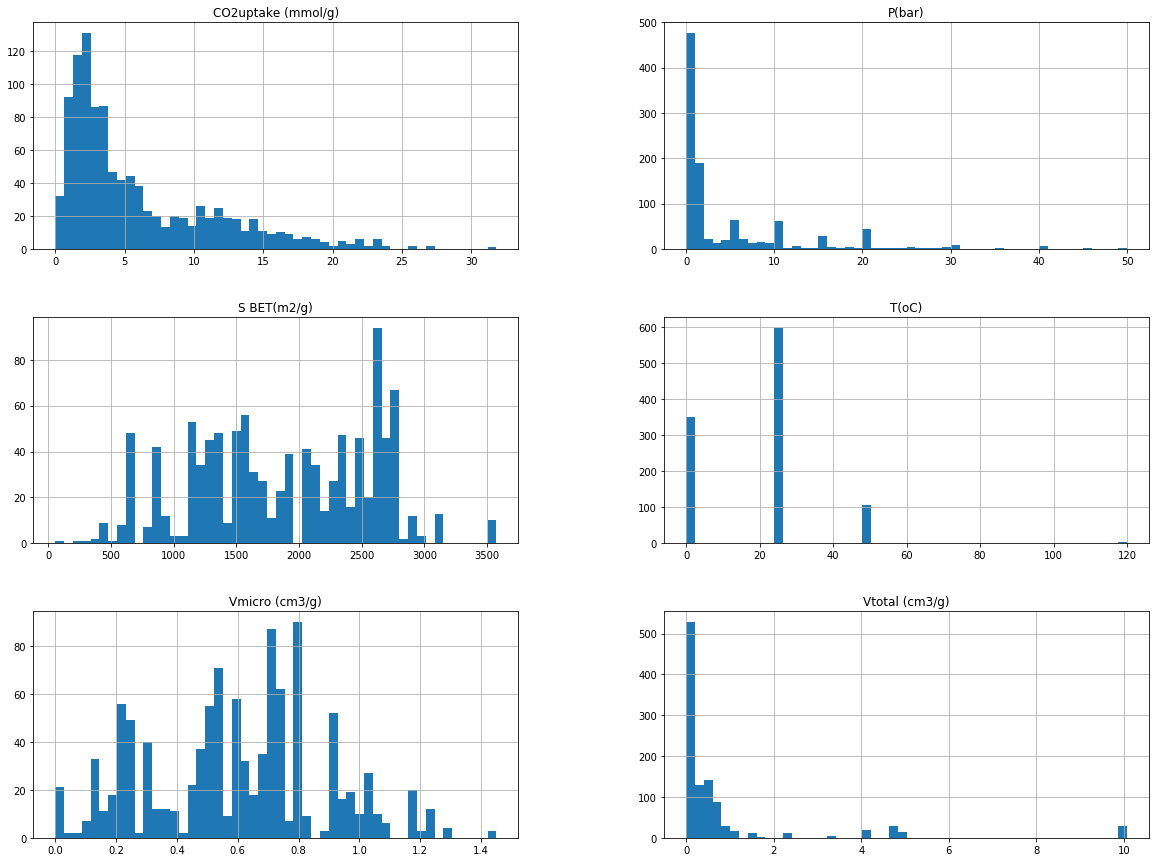

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()


From the histrograms above we see that most of the carbons have adsorption capacity in a range from 0 to 5 mmol/g.
Let us compute Pearson's correlation coefficient. If its value if close to 1, it means that the feature has strong correlation.

In [24]:
corr_matrix = df.corr()
corr_matrix['CO2uptake (mmol/g)'].sort_values()

T(oC)                -0.304654
Vtotal (cm3/g)       -0.116041
S BET(m2/g)           0.207388
Vmicro (cm3/g)        0.240016
P(bar)                0.714046
CO2uptake (mmol/g)    1.000000
Name: CO2uptake (mmol/g), dtype: float64

From the results it looks that pressure (P) has the strongest correlation with CO2 uptake. This is not surprising because the higher pressure, the more CO2 molecules adsorp. The lowest correlation coefficient has the temperature (T) and pore volume (Vtotal). The latter two are counter intuitive since adsorption is dependant on the temperature - the higher T, the less adsorption. However, the correlation coefficient is applicable only to linear corrections. For non linear relations, the corr. coefficient falls.   

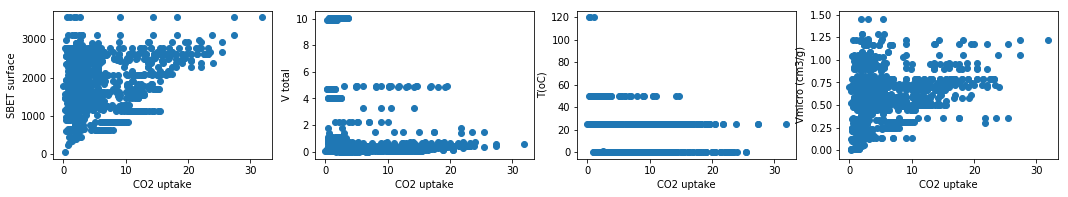

In [25]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

fig = plt.figure(figsize=(18,6))
plt.subplot2grid((2,4),(0,0))
plt.xlabel('CO2 uptake')
plt.ylabel('SBET surface')
plt.scatter(df['CO2uptake (mmol/g)'], df['S BET(m2/g)'])

plt.subplot2grid((2,4),(0,1))
plt.scatter(df['CO2uptake (mmol/g)'], df['Vtotal (cm3/g)'])
plt.ylabel('V total')
plt.xlabel('CO2 uptake')

plt.subplot2grid((2,4),(0,2))
plt.scatter(df['CO2uptake (mmol/g)'], df['T(oC)'])
plt.ylabel('T(oC)')
plt.xlabel('CO2 uptake')

plt.subplot2grid((2,4),(0,3))
plt.scatter(df['CO2uptake (mmol/g)'], df['Vmicro (cm3/g)'])
plt.ylabel('Vmicro (cm3/g)')
plt.xlabel('CO2 uptake')
plt.show()

Here we will create the validation set to avoid "in-sample" errors by splitting the dataset into the validation and test sets. But first let us create target, i.e. what we are going to predict (CO2 uptake, denoted as "y"), and features - X: 

In [26]:
y = df['CO2uptake (mmol/g)']
X = df.drop('CO2uptake (mmol/g)', axis=1)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)


### Decision Tree Regressor

We used this dataset of 1055 samples, which was splitted into training set to train the models and validation set to test the trained models.


In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

DTR_model = DecisionTreeRegressor()
DTR_model.fit(train_X, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [28]:
val_predictions_DTR = DTR_model.predict(val_X)
print("Mean abs error: " + str(round(mean_absolute_error(val_y, val_predictions_DTR),2)))

DTR_model.score(train_X, train_y)
acc_DecTree = round(DTR_model.score(train_X, train_y) * 100, 2)
print("Score Decision Tree Regressor: " + str(acc_DecTree))

#print("oob score:", round(DTR_model.oob_score_, 2)*100, "%")

Mean abs error: 0.59
Score Decision Tree Regressor: 100.0


The mean absolute error is 0.64. The mean absolute error (MAE) is a difference between actual and predicted values. Thus, the smaller, the better.

### Random Forest regressor

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

RFR_model = RandomForestRegressor(oob_score=True)
RFR_model.fit(train_X, train_y)
val_predictions_RFR = RFR_model.predict(val_X)


print("Mean abs error: " + str(round(mean_absolute_error(val_y, val_predictions_RFR),2)))

print("oob score:", round(RFR_model.oob_score_, 2)*100, "%")

RFR_model.score(train_X, train_y)
acc_random_forest = round(RFR_model.score(train_X, train_y) * 100, 2)
print("Score Random Forest regressor: " + str(acc_random_forest))

y_oob = RFR_model.oob_prediction_
len(val_y) 

Mean abs error: 0.56
oob score: 93.0 %
Score Random Forest regressor: 99.56


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


264

### XGBoost 

In [30]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(train_X, train_y, verbose=False)
predictions = my_model.predict(val_X)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, val_y)))

my_model.score(train_X, train_y)
acc_XGBoost = round(my_model.score(train_X, train_y) * 100, 2)

print("Score Random Forest regressor: " + str(acc_XGBoost))

Mean Absolute Error : 0.5328085586238991
Score Random Forest regressor: 98.7


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


## Analysis of the algoritms 

Let us summarize the model performance with different algoritms:

In [31]:
table = {'MAE': [round(mean_absolute_error(val_y, val_predictions_DTR),2),
                 round(mean_absolute_error(val_y, val_predictions_RFR),2),
                 round(mean_absolute_error(predictions, val_y),2)], 
        'Score': [acc_DecTree,
                  acc_random_forest,
                  acc_XGBoost]}
dff_2 = pd.DataFrame(table, index = ['Decision Tree Regressor', 'Random Forest Regressor', 'XGBoost'])
dff_2

,MAE,Score
Decision Tree Regressor,0.59,100.00
Random Forest Regressor,0.56,99.56
XGBoost,0.53,98.70


The samllest MAE was calculated for XGBoost and yet it has the lowest score. Very high score for Decision Tree and Random Forest algoritms is presumably due to the overfitting of the data. Thus, XRGBoost was chosen as an algoritm that performs best. 

So far we have taken 5 features into consideration - S BET, total volume of pores, volum of micropores, temperature and pressure. Now we will have a look on the performance of the model if only 3 features (dropping temperature and pressure) were taken into account. 

In [32]:
train2_X = train_X.drop('T(oC)', axis=1, inplace=True)
train2_X = train_X.drop('P(bar)', axis=1)
val2_X = val_X.drop('T(oC)', axis=1, inplace=True)
val2_X = val_X.drop('P(bar)', axis=1)

my_model_2 = XGBRegressor()
my_model_2.fit(train2_X, train_y, verbose=False)
predictions_2 = my_model_2.predict(val2_X)

print("Mean Absolute Error (with only 3 features) : " + str(mean_absolute_error(predictions_2, val_y)))
my_model_2.score(train2_X, train_y)
acc_XGBoost_2 = round(my_model_2.score(train2_X, train_y) * 100, 2)

print("Score Random Forest regressor (with 3 features): " + str(acc_XGBoost_2))

Mean Absolute Error (with only 3 features) : 2.955567257256219
Score Random Forest regressor (with 3 features): 42.29


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


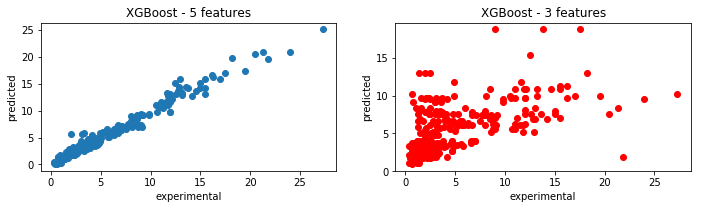

Mean Absolute Error (5 features): 0.53
Score Random Forest regressor (5 features): 98.7
Mean Absolute Error (with only 3 features) : 2.96
Score Random Forest regressor (with 3 features): 42.29


,With P and T,Without P and T
MAE,0.53,2.96
Score,98.70,42.29


In [33]:
fig = plt.figure(figsize=(18,6))
plt.subplot2grid((2,3),(0,0))
plt.title("XGBoost - 5 features")
plt.xlabel("experimental")
plt.ylabel("predicted")
plt.scatter(val_y, predictions)

plt.subplot2grid((2,3),(0,1))
plt.title("XGBoost - 3 features")
plt.xlabel("experimental")
plt.ylabel("predicted")
plt.scatter(val_y, predictions_2, c=["red"])

plt.show()

print("Mean Absolute Error (5 features): " + str(round(mean_absolute_error(predictions, val_y),2)))
print("Score Random Forest regressor (5 features): " + str(acc_XGBoost))

print("Mean Absolute Error (with only 3 features) : " + str(round(mean_absolute_error(predictions_2, val_y),2)))
print("Score Random Forest regressor (with 3 features): " + str(acc_XGBoost_2))

data = {'With P and T': [round(mean_absolute_error(predictions, val_y),2), acc_XGBoost], 
        'Without P and T': [round(mean_absolute_error(predictions_2, val_y),2), acc_XGBoost_2]}
dff = pd.DataFrame(data, index = ['MAE', 'Score'])
dff

## Test table set-up

Let us import experimental surface data on the samples without CO2 adsorption data. Again, all data for these simulations were extracted from this article:

https://onlinelibrary.wiley.com/doi/full/10.1002/anie.201812363

In [34]:
exp_por2 = DataFrame.from_csv("exper_samples.tsv", sep="\t")
exp_por2.drop([exp_por2.index[0], 'XC605'], inplace=True)
exp_por2['T(oC)']=[25,25,25,25,25,25]
exp_por2['P(bar)']=[5,5,5,5,5,5]
exp_por2['CO2_exp']=[1.36,2.02,2.25,2.79,5.46,0.32]
exp_por2

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,SBET,Vtotal,Vmicro,Vmeso,T(oC),P(bar),CO2_exp
Samples,,,,,,,
MC-450,346,0.51,0.05,0.46,25,5,1.36
MC-600,390,0.60,0.05,0.55,25,5,2.02
MC-850,451,0.67,0.06,0.61,25,5,2.25
AC Darco,625,0.57,0.14,0.43,25,5,2.79
AC Charcoal,1327,0.61,0.35,0.26,25,5,5.46
Vulcan,55,0.16,0,0.16,25,5,0.32


In [35]:
exp_por2.drop(['Vmeso'], axis=1, inplace=True)
exp_por2.columns = df.columns

for i in exp_por2.columns:
    exp_por2[i] = exp_por2[i].astype(float)

Y_exp = exp_por2['CO2uptake (mmol/g)']
X_new = exp_por2.drop('CO2uptake (mmol/g)', axis=1)

exp_por2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, MC-450 to Vulcan
Data columns (total 6 columns):
S BET(m2/g)           6 non-null float64
Vtotal (cm3/g)        6 non-null float64
Vmicro (cm3/g)        6 non-null float64
T(oC)                 6 non-null float64
P(bar)                6 non-null float64
CO2uptake (mmol/g)    6 non-null float64
dtypes: float64(6)
memory usage: 336.0+ bytes


The table for experimental adsorption data contains only numerical values and no missing values, which is good. Now let us predict the CO2 uptake and compare it with the experimental observed one.

Mean Absolute Error : 0.5235468292236328


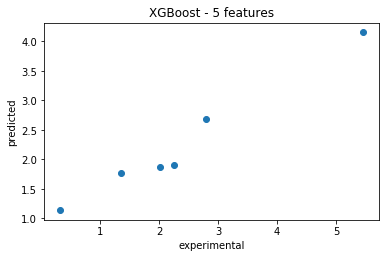

In [36]:
import matplotlib.pyplot as plt

predictions_new = my_model.predict(X_new)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions_new, Y_exp)))

plt.scatter(Y_exp, predictions_new)
plt.axis('scaled')
plt.title("XGBoost - 5 features")
plt.xlabel("experimental")
plt.ylabel("predicted")

plt.show()

Voila! There is a pretty good correlation between the epxrimental and predicted values! Although the used dataset was small (around 1000 instances), the developed model can still predict the adsorption values with quite high accuracy. 